In [2]:
import numpyro
import numpyro.distributions as dist
import numpy as np
import jax
import jax.numpy as jnp
from jax.config import config
config.update("jax_enable_x64", True)
config.update("jax_debug_nans", True)

#CPUs parallelization
import multiprocessing
max_thread_numbers=multiprocessing.cpu_count()
import os
os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=%d"%(max_thread_numbers)

# Eight Schools example
def eight_schools(J, sigma, y=None):
    mu = numpyro.sample('mu', dist.Normal(0, 5))
    tau = numpyro.sample('tau', dist.HalfCauchy(5))
    with numpyro.plate('J', J):
        theta = numpyro.sample('theta', dist.Normal(mu, tau))
        numpyro.sample('obs', dist.Normal(theta, sigma), obs=y)

x=np.arange(10)
y=3*x+1

@jax.jit
def log_prob(args):
    return -0.5*jnp.power(y-args[0]*x-args[1],2).mean()

In [11]:
%timeit log_prob([-7.932,4.476]).block_until_ready()

13.5 µs ± 30.2 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [3]:
log_prob([1,2])

DeviceArray(-48.5, dtype=float64)

In [4]:
jax.grad(log_prob)([1.,2.])

[DeviceArray(52.5, dtype=float64), DeviceArray(8., dtype=float64)]

In [6]:
from jax import random
from numpyro.infer import MCMC, NUTS, HMC

In [12]:
nwalkers=max_thread_numbers
numpyro.set_host_device_count(nwalkers)

nuts_kernel = HMC(potential_fn= lambda args: -log_prob(args))
mcmc = MCMC(nuts_kernel, num_warmup=500, num_samples=1000,num_chains=nwalkers)

In [13]:
rng_key = random.PRNGKey(0)
p0=np.repeat(np.expand_dims([1.,2.], axis=0), nwalkers, axis=0)
mcmc.run(rng_key,init_params=p0,extra_fields=('potential_energy',))

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

In [14]:
mcmc.print_summary()



                mean       std    median      5.0%     95.0%     n_eff     r_hat
Param:0[0]      3.00      0.34      3.00      2.45      3.57   7477.78      1.00
Param:0[1]      1.01      1.83      0.98     -2.14      3.88   6095.58      1.00

Number of divergences: 0


In [15]:
chain = mcmc.get_samples()


In [16]:
import corner


In [17]:
np.array(chain).shape

(8000, 2)

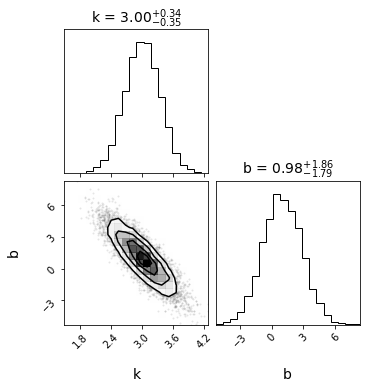

In [19]:

fig = corner.corner(np.array(chain), show_titles=True, labels=['k','b'],
                    title_kwargs={'fontsize': 14}, label_kwargs={'fontsize': 14})
